# 04 TFIDF vectorizer instead to find a better model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# TODO more model types can be imported here if interesting

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# we may choose to only optimize for Tfidf bc this structures the data with more information 
from nltk.corpus import stopwords

In [70]:
# Read in data
posts = pd.read_csv('./data/posts_cleaned.csv')
posts.head()

,created_utc,all_text,subreddit
0,2021-01-31 16:31:41,I gave someone oral sex as a means to pacify t...,1
1,2023-03-22 16:14:59,The cable man took the key to my apartment\n\n...,1
2,2024-02-26 22:36:25,how do i know if im in gay love with my friend...,1
3,2012-08-07 22:42:45,"Woman here, would someone mind clarifying some...",0
4,2013-01-20 14:42:18,This article about Hillary Clinton's egalitari...,0


In [71]:
X = posts['all_text']
y = posts['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [72]:
# Set up a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [2000, 3000, 4000, 5000, None]
}

gs = GridSearchCV(pipe, params, n_jobs=8)

In [73]:
%%time
gs.fit(X_train, y_train)

CPU times: user 3.44 s, sys: 1.49 s, total: 4.93 s
Wall time: 1min 10s


GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=8,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000, None],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [78]:
gs.score(X_train, y_train)

0.8565276518585675

In [79]:
gs.score(X_test, y_test)

0.7845003399048266

In [11]:
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False).iloc[:5, 4:]

,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,param_tvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
43,5000,2,"(1, 2)",english,"{'tvec__max_features': 5000, 'tvec__min_df': 2...",0.812005,0.779162,0.803855,0.786848,0.765306,0.789435,0.016803,1
47,5000,3,"(1, 2)",english,"{'tvec__max_features': 5000, 'tvec__min_df': 3...",0.809740,0.781427,0.807256,0.785714,0.759637,0.788755,0.018403,2
39,5000,1,"(1, 2)",english,"{'tvec__max_features': 5000, 'tvec__min_df': 1...",0.809740,0.780294,0.803855,0.787982,0.760771,0.788528,0.017455,3
31,4000,2,"(1, 2)",english,"{'tvec__max_features': 4000, 'tvec__min_df': 2...",0.812005,0.782559,0.797052,0.790249,0.760771,0.788527,0.016928,4
35,4000,3,"(1, 2)",english,"{'tvec__max_features': 4000, 'tvec__min_df': 3...",0.809740,0.780294,0.799320,0.790249,0.759637,0.787848,0.017144,5


The kind of vectorizer did not improve the overall model score very much.  We seek a better classification model type than Multinomial Naive Bayes. We will try LogisticRegression

In [80]:
gs.best_params_

{'tvec__max_features': 5000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [81]:
gs.best_estimator_[0].get_feature_names_out()[-10:]

array(['young people', 'young woman', 'young women', 'younger', 'youth',
       'youtu', 'youtube', 'youtube com', 'yrs', 'zero'], dtype=object)

In [69]:
posts[posts['all_text'].str.lower().str.contains('zealand')]

,created_utc,all_text,subreddit
1228,2021-03-24 14:10:52,New Zealand Parliament unanimously passes bere...,1
1281,2020-06-25 19:33:49,Supermarket in New Zealand to ditch terms like...,1
1285,2020-03-19 10:16:38,New Zealand's parliament has passed a bill dec...,1
1297,2021-02-18 00:38:27,New Zealand's Jacinda Ardern announces the Gov...,1
1445,2020-03-18 07:57:52,Abortion legalised in New Zealand with Parliam...,1
1491,2018-06-21 06:58:50,New Zealand Prime Minister Jacinda Ardern beco...,1
3352,2024-02-13 06:15:15,New Zealand Justice Committee is going to tabl...,0


In [66]:
posts['all_text'] # .str.lower()

0       What are some fashion choices men have given y...
1       I feel insane - IUD stories? \n\nHi all, I hav...
2       questions for anyone with the birth control ar...
3       Running Through Fear: Kosovar Women Jog In Gro...
4       I’m so sick of the low effort men put into the...
                              ...                        
5878    The Physical and Psychological Differences Bet...
5879    FB yielded a good example of the double standa...
5880    Incident at work today (not a discrimination i...
5881    As a woman,\n\nI really want to support your m...
5882    "Dead-Beat Dads" is a myth....\n\n A long time...
Name: all_text, Length: 5883, dtype: object

## Use a logistic regression to see if we find a better model

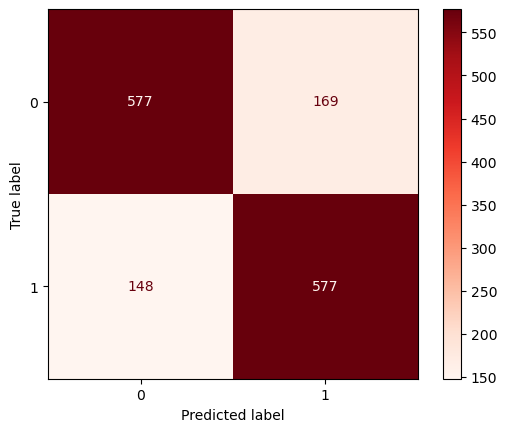

In [83]:
# make the features from some tokenizer strategy
# fit to logreg
# examine score

ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds');